In [1]:
!pip install albumentations
import albumentations

In [2]:
import os
import json
import numpy as np
import pandas as pd
import shutil
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt

%matplotlib inline

import sklearn
import tensorflow as tf
import tensorflow_addons as tfa
from PIL import Image

from sklearn.model_selection import (
    StratifiedKFold,
    StratifiedShuffleSplit,
    train_test_split,
)
from tensorflow import keras
from tensorflow.keras.applications.efficientnet import EfficientNetB4, EfficientNetB7, EfficientNetB0
from tensorflow.keras.layers import (
    AveragePooling2D,
    AvgPool2D,
    Conv2D,
    Dense,
    Flatten,
    GlobalAveragePooling2D,
    MaxPooling2D,
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import notebook, tqdm

In [23]:
IMAGE_SIZE = 380
PATH = "/app/_data/"
IMG_PATH = "/app/_data/train_images/"
MODEL_PATH = '/app/_data/models/new/bond_box_999_200.h5'
DF_PATH = '../_data/df_csv/df_boxes_colab.csv'
TARGET_IMG_PATH = '/app/_data/cropped_all_v1/'

# crop + resize

In [4]:
df_crop = pd.read_csv(DF_PATH)
df_crop.columns = ['image', 'x_min', 'y_min', 'x_max', 'y_max']

In [5]:
df_crop[df_crop['image'].str.contains('est')]

,image,x_min,y_min,x_max,y_max
18632,Test_363.jpg,0.277802,0.077086,0.698284,0.889916
18638,Test_525.jpg,0.002395,0.127495,0.859940,0.920759
18642,Test_947.jpg,0.116355,0.023865,0.914699,0.726426
18644,Test_1367.jpg,0.096015,0.213608,0.915575,0.885561
18645,Test_589.jpg,0.104666,0.246314,0.809188,0.930086
...,...,...,...,...,...
22264,Test_1583.jpg,0.245878,0.129060,0.715200,0.863365
22266,Test_382.jpg,0.079420,0.091538,0.948693,0.970366
22269,Test_1140.jpg,0.082660,0.224326,0.790734,0.938389
22270,Test_606.jpg,0.333407,0.360054,0.687298,0.749096


In [54]:
test_20_labeled = pd.read_csv('../_data/df_csv/test20_labeled.csv', index_col=[0])
test_20_imgs = test_20_labeled['image'].tolist()

In [58]:
# def write_np(file_path, df, target_path):
#     img = tf.io.read_file(IMG_PATH+ file_path)
#     img = tf.image.decode_jpeg(img, channels=3)
#     coord = df[df["image"] == file_path][['x_min', 'y_min', 'x_max', 'y_max']].values[0]
#     orig_hight = img.shape[0]
#     orig_width = img.shape[1]
#     x_min = coord[0]
#     y_min = coord[1]
#     x_max = coord[2]
#     y_max = coord[3]
#     cropped_image = img.numpy()[np.int(y_min*orig_hight):np.int(y_max*orig_hight),np.int(x_min*orig_width):np.int(x_max*orig_width)]
#     img = tf.image.resize(cropped_image, (IMAGE_SIZE, IMAGE_SIZE))
#     img = tf.cast(img, dtype='uint8')
#     img = Image.fromarray(img.numpy())
#     if os.path.exists(target_path) ==False:
#         os.makedirs(target_path)
#     img.save(target_path+file_path)
# #     return img
# # # labels_21_20['image'].apply(write_np)
# # all_imgs = os.listdir(PATH + 'train_images/')
# for i in tqdm(range(len(test_20_imgs))):
#     if test_20_imgs[i] in df_crop["image"].values:
#          write_np(test_20_imgs[i],df_crop, TARGET_IMG_PATH)

100%|██████████| 900/900 [00:19<00:00, 46.90it/s]


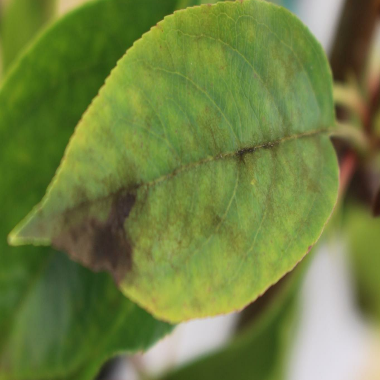

In [53]:
write_np('Test_1141.jpg', df_crop, TARGET_IMG_PATH)

In [ ]:
# def write_np(file_path):
#     img = tf.io.read_file(TRAIN_IMG_PATH + file_path)
#     img = tf.image.decode_jpeg(img, channels=3)
#     img = tf.image.convert_image_dtype(img, tf.float32)
#     img = tf.image.resize(
#         img,
#         IMAGE_SIZE,
#     )
#     img = tf.image.convert_image_dtype(img, tf.uint8)
# #     img = Image.fromarray(np.array(img))
#     if not os.path.exists(TARGET_IMG_PATH):
#         os.mkdir(TARGET_IMG_PATH)
#     img.save(PATH + '380/'+file_path)
#     return img
#     np.save(PATH + 'cache/'+file_path[:-4], img)
# labels['image'].apply(write_np)

In [6]:
# for 380*380
transform = albumentations.Compose(
    [
        albumentations.CLAHE(p=0.1, clip_limit=(1, 2), tile_grid_size=(8, 8)),
        albumentations.OneOf(
            [
                albumentations.MotionBlur((3, 3)),
                albumentations.MedianBlur(blur_limit=3),
                albumentations.GaussianBlur(
                    blur_limit=(3, 3), sigma_limit=0),
                albumentations.Blur(blur_limit=(3, 3)),
            ],
            p=0.2,
        ),
        albumentations.OneOf(
            [
                albumentations.GaussNoise(var_limit=[10, 50], mean=1),
                albumentations.ISONoise(intensity=(0.1, 1), color_shift=(0.01, 0.05)),
                albumentations.ImageCompression(
                    quality_lower=70, quality_upper=100, compression_type=1
                ),
                albumentations.MultiplicativeNoise(
                    multiplier=(0.95, 1.05), per_channel=True, elementwise=True
                ),
                albumentations.Downscale(
                    scale_min=0.6, scale_max=0.99, interpolation=4
                ),
            ],
            p=1,
        ),
        albumentations.OneOf(
            [
                albumentations.HueSaturationValue(
                    hue_shift_limit=(-7, 7),
                    sat_shift_limit=(-10, 10),
                    val_shift_limit=(-10, 10),
                ),
                albumentations.RandomBrightnessContrast(
                    brightness_limit=0.15,
                    contrast_limit=0.2,
                    brightness_by_max=True,
                ),
            ],
            p=1,
        ),
        albumentations.OneOf(
            [
                albumentations.OpticalDistortion(
                    distort_limit=0.05,
                    shift_limit=0.05,
                    border_mode=2,
                ),
                albumentations.ElasticTransform(
                    alpha=2.0,
                    sigma=50.0,
                    alpha_affine=10.0,
                    interpolation=0,
                    border_mode=2,
                ),
                albumentations.GridDistortion(
                    num_steps=5, distort_limit=0.3, interpolation=0, border_mode=2
                ),
            ],
            p=1,
        ),
        albumentations.OneOf(
            [
                albumentations.HorizontalFlip(),
                albumentations.VerticalFlip(),
            ],
            p=1,
        ),
        albumentations.OneOf(
            [
                albumentations.Rotate(
                    limit=(-180, 180), interpolation=0, border_mode=2
                ),
                albumentations.ShiftScaleRotate(
                    shift_limit=0.05,
                    scale_limit=0.05,
                    rotate_limit=180,
                    interpolation=0,
                    border_mode=2,
                ),
            ],
            p=1,
        ),
    ]
)

In [9]:
df = pd.read_csv('/app/sandbox/wrong_predictions/eff4/wrong_eff4_ids.csv')

In [30]:
def write_np(file_path, new_file_path):
    img = tf.io.read_file(TARGET_IMG_PATH + file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img  = transform(image=np.array(img))['image']
    img = Image.fromarray(np.array(img))
    img.save(TARGET_IMG_PATH+new_file_path)
#     return img


In [36]:
df[df['image'].str.contains('rai')]['image'] in 

349    Train_1013.jpg
350    Train_1035.jpg
351    Train_1050.jpg
352    Train_1173.jpg
353     Train_122.jpg
354    Train_1236.jpg
355    Train_1270.jpg
356    Train_1433.jpg
357    Train_1454.jpg
358    Train_1526.jpg
359    Train_1609.jpg
360    Train_1618.jpg
361     Train_170.jpg
362    Train_1784.jpg
363     Train_303.jpg
364     Train_306.jpg
365     Train_336.jpg
366     Train_484.jpg
367     Train_535.jpg
368      Train_62.jpg
369     Train_645.jpg
370     Train_905.jpg
371     Train_936.jpg
372      Train_95.jpg
373     Train_998.jpg
Name: image, dtype: object

In [25]:
labels_21_20 = pd.read_csv('../_data/df_csv/labels_21_20.csv', index_col=[1])
labels_21_20.sample()

,Unnamed: 0,labels,complex,frog_eye_leaf_spot,healthy,powdery_mildew,rust,scab
image,,,,,,,,
9d9a916b81e74527.jpg,3561,scab,0,0,0,0,0,1


In [38]:
for img_name in tqdm(df['image'].tolist()):
    if img_name in labels_21_20.index:
        for i in range(1, 4):
            new_name = str(i)+'_'+img_name
            labels_21_20.loc[new_name] = labels_21_20.loc[img_name]
            write_np(img_name, new_name)


100%|██████████| 2059/2059 [07:39<00:00,  4.48it/s]


In [40]:
labels_21_20.to_csv('/app/_data/df_csv/labels_21_20_plus_wrong_upsample.csv')